## AML08 Natural Language Processing with RNNs

( Chapter 16 – part1)

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [3]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#if not tf.config.list_physical_devices('GPU'):
#    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
#    if IS_COLAB:
#        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
# If auto-complete (TAB after '.' doesn't work): 
# pip3 install pyreadline

%config IPCompleter.use_jedi = False

## Char-RNN

### Splitting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))

dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))               # << flatten 
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)

for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


### Loading the Data and Preparing the Dataset

In [6]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)

with open(filepath) as f:
    shakespeare_text = f.read()

In [7]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [8]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [9]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [10]:
tokenizer.texts_to_sequences(["Second"])

[[8, 2, 19, 4, 10, 13]]

In [11]:
tokenizer.sequences_to_texts([[8, 2, 19, 4, 10, 13]])

['s e c o n d']

In [12]:
print(tokenizer.word_index)

{' ': 1, 'e': 2, 't': 3, 'o': 4, 'a': 5, 'i': 6, 'h': 7, 's': 8, 'r': 9, 'n': 10, '\n': 11, 'l': 12, 'd': 13, 'u': 14, 'm': 15, 'y': 16, 'w': 17, ',': 18, 'c': 19, 'f': 20, 'g': 21, 'b': 22, 'p': 23, ':': 24, 'k': 25, 'v': 26, '.': 27, "'": 28, ';': 29, '?': 30, '!': 31, '-': 32, 'j': 33, 'q': 34, 'x': 35, 'z': 36, '3': 37, '&': 38, '$': 39}


In [13]:
max_id = len(tokenizer.word_index)      # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [14]:
max_id, dataset_size

(39, 1115394)

In [15]:
### Sentences as sequnces of numbers

[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [16]:
encoded[20:30]

array([ 1,  0, 16,  1,  0, 22,  8,  3, 18,  1])

In [17]:
shakespeare_text[20:30]

'e we proce'

#### define target for modeling

In [18]:
n_steps = 100
window_length = n_steps + 1       # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [19]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [22]:
## 1-hot encoding of tokens

In [23]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [24]:
dataset = dataset.prefetch(1)

In [25]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


### Creating and Training the Model 

### Stateless version

<font size=4><font color='red'>Training the model defined below takes too long on a small machine.</font> 
<font color='blue'>So, it was trained in Colab and downloaded to my local machine.</font>  
    
<font size=3>Instructions how to do that - after loading the model</font>

In [26]:
dir_models = '/Users/iordan/Documents/Statistics/Hunter/Advanced ML_STAT725/2022/code/'

In [27]:
### === Load the model ====

model_char = keras.models.load_model(dir_models+'my_char_gru_tf.h5', compile=False)  # Do not 'compile'!

### Download models from Colab

In [28]:
### Run this in Colab! 

# (1) Mount (connect to) your Google Drive (if you have a Google account/e-mail then you have one) 

# from google.colab import drive
# drive.mount('/content/gdrive')

In [29]:
# How to mount + more ways to access Colab:
#
#  https://neptune.ai/blog/google-colab-dealing-with-files

In [30]:
# (2) Save model built above in Colab to your Google Drive

## model.save("/content/gdrive/MyDrive/name_of_your_model.h5")
# model_char.save("/content/gdrive/MyDrive/saved_models/my_char_gru.h5")

In [31]:
# (3) Download to your local machine (you can use the Google drive gui)
# (4) Load model in the local (this) notebook

### Using the Model to Generate Text

In [32]:
def preprocess_oh(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [33]:
X_new = preprocess_oh(["How are yo"])
X_new = preprocess_oh(["Give me fiv"])
Y_pred = model_char.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'e'

In [34]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]])

In [35]:
### Use the generic name 'model'
model = model_char

In [36]:
# (1) Generate next character of a string

def next_char(text, temperature=1):
    X_new = preprocess_oh([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [37]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [38]:
# (2) Generate longer text - use "temperature"

def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [39]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

t the matter to her word,
and so well man in padua 


In [40]:
print(complete_text("t", temperature=1))

this keep you myut;
and make his houses our trimisy


In [41]:
print(complete_text("t", temperature=2))

ts no gwe:
mean'-an for you 'er griutto:twact, scac


### Stateful RNN

In [42]:
tf.random.set_seed(42)

In [43]:
encoded.shape, train_size

((1115394,), 1003854)

In [44]:
### Training set is built differently

# (a) shift=n_steps - non-overlapping sequences
# (b) No shuffling
# ...

In [45]:
# Example when batches contain a single window (*)

dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)  # (a)

dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)   # <=== (*)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [55]:
# Batch size is increased to 32 - **use this data set up
# "...create proper consecutive batches, where the nth input sequence in a batch starts off exactly where the nth input sequence ended in the previous batch"

batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)

# stack the windows
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

**Note**: once again, I commented out `recurrent_dropout=0.2` (compared to the book) so you can get GPU acceleration (if you have one).

In [51]:
### NB: 'stateful=True' in the GRU layers

model_sfull = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [52]:
### Sets to zero the hidden states after each epoch

In [53]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [56]:
model_sfull.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history_sfull = model_sfull.fit(dataset, epochs=3,
                   callbacks=[ResetStatesCallback()])

Epoch 1/3
313/313 [==============================] - 155s 496ms/step - loss: 2.6234
Epoch 2/3
313/313 [==============================] - 156s 499ms/step - loss: 2.2426
Epoch 3/3
313/313 [==============================] - 163s 522ms/step - loss: 2.1103


In [62]:
### The stateful model is fit faster, so we can train an example version (with 3 epochs on the local machine) 

In [63]:
# On COLAB:
#-------------------------------------------------------------------------------
# model_sfull.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
# history_sfull = model_sfull.fit(dataset, epochs=50,
#                   callbacks=[ResetStatesCallback()])3

In [44]:
# Epochs = 50 - DONT't run

Epoch 1/50
313/313 [==============================] - 8s 13ms/step - loss: 2.6211
Epoch 2/50
313/313 [==============================] - 4s 13ms/step - loss: 2.2422
Epoch 3/50
313/313 [==============================] - 4s 13ms/step - loss: 2.1109
Epoch 4/50
313/313 [==============================] - 4s 13ms/step - loss: 2.0358
Epoch 5/50
313/313 [==============================] - 4s 13ms/step - loss: 1.9854
Epoch 6/50
313/313 [==============================] - 4s 13ms/step - loss: 1.9480
Epoch 7/50
313/313 [==============================] - 4s 13ms/step - loss: 1.9206
Epoch 8/50
313/313 [==============================] - 4s 13ms/step - loss: 1.8991
Epoch 9/50
313/313 [==============================] - 4s 13ms/step - loss: 1.8817
Epoch 10/50
313/313 [==============================] - 4s 13ms/step - loss: 1.8661
Epoch 11/50
313/313 [==============================] - 4s 13ms/step - loss: 1.8533
Epoch 12/50
313/313 [==============================] - 4s 13ms/step - loss: 1.8419
Epoch 13/50
3

In [64]:
### Much fastrer in Colab - can again fit model there, then downloaded

To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since it is only used during training:

In [65]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [66]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [67]:
stateless_model.set_weights(model_sfull.get_weights())
# model = stateless_model

In [68]:
model = stateless_model

In [69]:
tf.random.set_seed(42)
print(complete_text("t"))

thiz:
your york?
werh nogher thou lactingw,
wn he m


In [51]:
### Save to Google drive if trained in Colab

# model_sfull.save("/content/gdrive/MyDrive/saved_models/my_char_statefull.h5")
# stateless_model.save("/content/gdrive/MyDrive/saved_models/my_char_stateless_v2.h5")

## Sentiment Analysis

In [70]:
tf.random.set_seed(42)

You can load the IMDB dataset easily:

In [71]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

/Users/iordan/anaconda3/envs/AML_TF/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/iordan/anaconda3/envs/AML_TF/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [72]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [73]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}

for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
    
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

In [74]:
### install widgets for code below to work

## (Step1 if you use Jupyter lab) 
##  conda install -n base -c conda-forge jupyterlab_widgets 

# conda install -c conda-forge ipywidgets

In [75]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

In [76]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [77]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [78]:
train_size, test_size

(25000, 25000)

In [79]:
for X_batch, y_batch in datasets["train"].batch(4).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: A very close and sharp discription of the bubbling and dynamic emotional world of specialy one 18year old guy, that makes his first experiences in his gay love to an other boy, during an vacation with ...
Label: 1 = Positive

Review: I saw this film on True Movies (which automatically made me sceptical) but actually - it was good. Why? Not because of the amazing plot twists or breathtaking dialogue (of which there is little) but b ...
Label: 1 = Positive

Review: I absolutely LOVED this movie when I was a kid. I cried every time I watched it. It wasn't weird to me. I totally identified with the characters. I would love to see it again (and hope I wont be disap ...
Label: 1 = Positive

Review: Oh yeah! Jenna Jameson did it again! Yeah Baby! This movie rocks. It was one of the 1st movies i saw of her. And i have to say i feel in love with her, she was great in this move.<br /><br />Her perfo ...
Label: 1 = Positive



In [80]:
### Restrict batch size to 300

In [81]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [82]:
preprocess(X_batch, y_batch)

(<tf.Tensor: id=16500, shape=(4, 60), dtype=string, numpy=
 array([[b'A', b'very', b'close', b'and', b'sharp', b'discription', b'of',
         b'the', b'bubbling', b'and', b'dynamic', b'emotional', b'world',
         b'of', b'specialy', b'one', b'year', b'old', b'guy', b'that',
         b'makes', b'his', b'first', b'experiences', b'in', b'his',
         b'gay', b'love', b'to', b'an', b'other', b'boy', b'during',
         b'an', b'vacation', b'with', b'a', b'part', b'of', b'his',
         b'family', b'I', b'liked', b'this', b'film', b'because', b'of',
         b'his', b'extremly', b'clear', b'and', b'surrogated', b'sto',
         b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
         b'<pad>'],
        [b'I', b'saw', b'this', b'film', b'on', b'True', b'Movies',
         b'which', b'automatically', b'made', b'me', b'sceptical', b'but',
         b'actually', b'it', b'was', b'good', b'Why', b'Not', b'because',
         b'of', b'the', b'amazing', b'plot', b'twists', b'or',
   

In [83]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [84]:
vocabulary.most_common()[:3]

[(b'<pad>', 215157), (b'the', 61137), (b'a', 38564)]

In [85]:
len(vocabulary)

53893

In [86]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [87]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [88]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [89]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: id=118201, shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [90]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [91]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[   22    11  1731 ...     0     0     0]
 [    6    94    13 ...     0     0     0]
 [ 1343     2   191 ...     0     0     0]
 ...
 [10494  1705   673 ...     0     0     0]
 [    6   145     2 ...     0     0     0]
 [    6    11   116 ...     0     0     0]], shape=(32, 66), dtype=int64)
tf.Tensor([1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1], shape=(32,), dtype=int64)


In [54]:
# Sequential model version

embed_size = 128
model_imdb = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model_imdb.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history_imdb = model_imdb.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 314s 403ms/step - loss: 0.5305 - accuracy: 0.7279
Epoch 2/5
781/781 [==============================] - 296s 379ms/step - loss: 0.3496 - accuracy: 0.8560
Epoch 3/5
781/781 [==============================] - 293s 375ms/step - loss: 0.2007 - accuracy: 0.9282
Epoch 4/5
781/781 [==============================] - 295s 377ms/step - loss: 0.1240 - accuracy: 0.9562
Epoch 5/5
781/781 [==============================] - 298s 382ms/step - loss: 0.1045 - accuracy: 0.9623


Or using manual masking:

In [92]:
## Functional API

K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)

z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)

model_imdb2 = keras.models.Model(inputs=[inputs], outputs=[outputs])
model_imdb2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history_imdb2 = model_imdb2.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 325s 416ms/step - loss: 0.5459 - accuracy: 0.7187
Epoch 2/5
781/781 [==============================] - 312s 400ms/step - loss: 0.3520 - accuracy: 0.8554
Epoch 3/5
781/781 [==============================] - 322s 413ms/step - loss: 0.1910 - accuracy: 0.9313
Epoch 4/5
781/781 [==============================] - 325s 416ms/step - loss: 0.1182 - accuracy: 0.9588
Epoch 5/5
781/781 [==============================] - 315s 404ms/step - loss: 0.0894 - accuracy: 0.9676


In [93]:
history_imdb2.history, history_imdb2.history

({'loss': [0.545881613020555,
   0.3519703690797358,
   0.1910023641237147,
   0.11818282651952283,
   0.0893543228675777],
  'accuracy': [0.71866995, 0.8553937, 0.931258, 0.9587868, 0.9675896]},
 {'loss': [0.545881613020555,
   0.3519703690797358,
   0.1910023641237147,
   0.11818282651952283,
   0.0893543228675777],
  'accuracy': [0.71866995, 0.8553937, 0.931258, 0.9587868, 0.9675896]})

In [94]:
### Measure performnace

Saving figure keras_learning_curves_plot


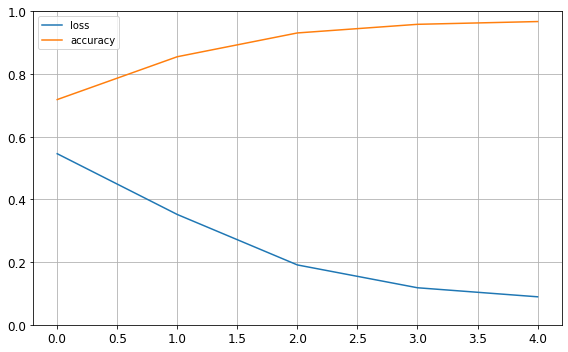

In [95]:
import pandas as pd

pd.DataFrame(history_imdb2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [96]:
history_imdb2.params

{'batch_size': None,
 'epochs': 5,
 'steps': 781,
 'samples': 781,
 'verbose': 1,
 'do_validation': False,
 'metrics': ['loss', 'accuracy']}

In [97]:
### Predict on test data

In [98]:
tst_set = datasets["test"].batch(1).map(preprocess) # test
tst_set = tst_set.map(encode_words).prefetch(1)

In [99]:
y_proba = model_imdb2.predict(tst_set)
pred = y_proba.flatten()

<AxesSubplot:>

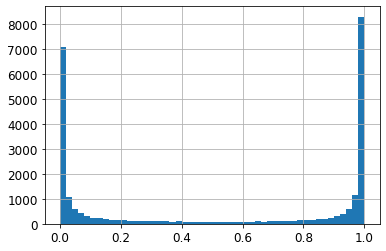

In [100]:
pd.Series(pred).hist(bins=50)

In [103]:
# [v for v in tst_set.as_numpy_iterator()][:4]

In [104]:
pred[:5]

array([0.9942688 , 0.99023026, 0.9946372 , 0.9938146 , 0.8316818 ],
      dtype=float32)

In [105]:
y_test[:5]

array([0, 1, 1, 0, 1])

In [106]:
### Metrics

In [107]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

In [108]:
# Confusion matrix

def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total Positive (Actual): ', np.sum(cm[1]))

In [109]:
# ROC
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'violet', 'orange', 'purple']
    
def plot_roc(name, labels, predictions, **kwargs):
    
    #plt.figure(figsize = (6, 6))
    plt.style.use('ggplot')
    
    fp, tp, _ = roc_curve(labels, predictions)

    lbl = name + " AUC: "+str(round(roc_auc_score(1-labels, 1-predictions.ravel()),3))
    plt.plot(100*fp, 100*tp, label=lbl, linewidth=2, **kwargs)
    plt.plot(100*fp, 100*fp,'r--');
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    #plt.grid(True)
    
    #plt.plot(fpr, tpr, label = "ROC score: "+str(round(roc_auc_score(1-y_test, 1-pred_vals[:,1]),3)), color = "violet", lw = 3);

    ax = plt.gca()
    ax.set_aspect('equal')

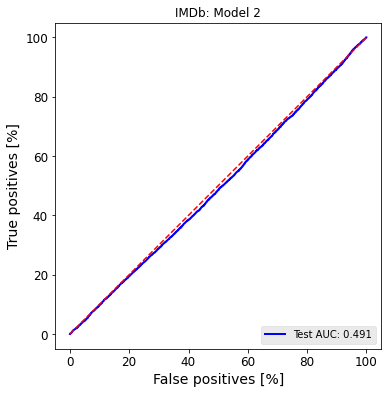

In [110]:
plt.figure(figsize = (6, 6))

plt.title('IMDb: Model 2')
plot_roc("Test", y_test, pred, color=colors[2]) #, linestyle='--')
plt.legend(loc='lower right')

True Negatives:  5834
False Positives:  6666
False Negatives:  6040
True Positives:  6460
Total Positive (Actual):  12500


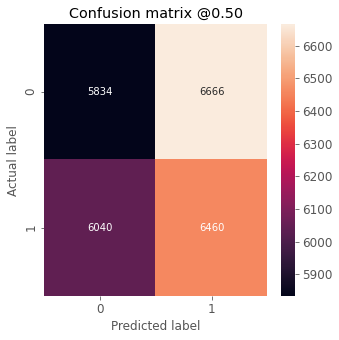

In [111]:
plot_cm(y_test,pred)

In [112]:
### Open question: What is the reason for the bad performance on test data?

# 1) The order of (observations with) the predicted probabilities somehow doesn't matcht the order (observations with) of the binary labels

# 2) Model overfits on train data (there is no validation data) and thus fails on test data

# 3) Vocabulary is built on train data - may be test data has very different set if words (and they get coded in the "overflow" buckets - oov)

## Reusing Pretrained Embeddings

In [113]:
tf.random.set_seed(42)

In [114]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [115]:
# !conda install -c anaconda tensorflow-hub -y

In [116]:
import tensorflow_hub as hub

In [117]:
model_imdb3 = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model_imdb3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [118]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [119]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history_imdb3 = model_imdb3.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Train for 781 steps
Epoch 1/5
781/781 [==============================] - 33s 42ms/step - loss: 0.5492 - accuracy: 0.7234
Epoch 2/5
781/781 [==============================] - 36s 46ms/step - loss: 0.5137 - accuracy: 0.7496
Epoch 3/5
781/781 [==============================] - 35s 45ms/step - loss: 0.5079 - accuracy: 0.7537
Epoch 4/5
781/781 [==============================] - 31s 40ms/step - loss: 0.5055 - accuracy: 0.7540
Epoch 5/5
781/781 [==============================] - 33s 42ms/step - loss: 0.5010 - accuracy: 0.7570


In [120]:
# y_proba = model_imdb3.predict(tst_set)

## Automatic Translation - <font color='red'>DONT'T RUN - coplied from COLAB!</font>

In [112]:
tf.random.set_seed(42)

In [113]:
vocab_size = 100
embed_size = 10

In [114]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model_trans = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

In [115]:
model_trans.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [116]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history_trans = model_trans.fit([X, X_decoder, seq_lengths], Y, epochs=5)

Epoch 1/5
32/32 [==============================] - 5s 39ms/step - loss: 4.6052
Epoch 2/5
32/32 [==============================] - 1s 38ms/step - loss: 4.6037
Epoch 3/5
32/32 [==============================] - 1s 38ms/step - loss: 4.6016
Epoch 4/5
32/32 [==============================] - 1s 38ms/step - loss: 4.5987
Epoch 5/5
32/32 [==============================] - 1s 39ms/step - loss: 4.5939


In [117]:
history_trans.history

{'loss': [4.60523796081543,
  4.603715896606445,
  4.6016154289245605,
  4.598698139190674,
  4.593866348266602]}

#### Automatic Translation - local machine installation of 'tensorflow-addons' not working

In [121]:
tf.random.set_seed(42)

In [122]:
vocab_size = 100
embed_size = 10

In [123]:
#!conda install -c anaconda tensorflow_addons -y
#!conda install -c esri tensorflow-addons -y
# !pip install tensorflow-addons

In [124]:
# import tensorflow_addons as tfa

### Bidirectional Recurrent Layers

In [125]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# https://stackoverflow.com/questions/54733395/how-should-i-deploy-the-trained-model-from-google-colab-to-my-computer

In [134]:
# !conda install -c conda-forge google-colab -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.0
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /Users/iordan/anaconda3/envs/AML_TF

  added / updated specs:
    - google-colab


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.10.8          |   py37hf985489_2         145 KB  conda-forge
    google-colab-1.0.0         |     pyh44b312d_0          77 KB  conda-forge
    openssl-1.1.1n             |       h6c3fc93_0         1.9 MB  conda-forge
    portpicker-1.5.0           |     pyhd8ed1ab_0          17 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.1 MB

The following NEW packages will be INSTALLED:

  google-colab       conda-forge/noarch::